# Overview

What separates the Hall of Fame from the Hall of Very Good? In this exploration, I look at the set of players who were nominated for entry into baseball's Hall of Fame. 

In this report, we find correlations among pitching, fielding, batting statistics, and awards with entry into the Hall of Fame. We also explore how they break down by position and explore whether or not the steroids era of baseball has had any effect.

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline
pd.set_option('display.max_columns', None)

# Data Wrangling
The dataset consists of pitching, hitting, and fielding statistics for Major League Baseball from 1871 through 2014. Each table is represented by a CSV file, with playerID being a unique ID we can use for merging.

To wrangle this data together, I performed the following steps:

* Load the Hall of Fame table.
* Merge in Master to add names.
* Merge in Award information.
* Merge in Appearances.
* Merge in Pitching statistics.
* Merge in Batting statistics.
* Merge in Fielding statistics.

## Master

In [122]:
hof_df = pd.read_csv('baseballdatabank-master/core/HallOfFame.csv')
master_df = pd.read_csv('baseballdatabank-master/core/Master.csv', parse_dates=['debut', 'finalGame'])

hof_cols = ['playerID', 'nameFirst', 'nameLast'] + list(hof_df.columns[1:]) 

hof_df = hof_df.merge(master_df, on='playerID')
hof_df = hof_df[hof_cols]

hof_df.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,wagneho01,Honus,Wagner,1936,Veterans,78.0,59.0,5.0,N,Player,NaN
4,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN


Since each row in the Hall of Fame set reflects a voting record, we group by playerID to remove duplicate rows. We end up with a single data frame of players, where the `inducted` field marks whether or not they are in the Hall of Fame.

There are 247 inducted players and 941 non-inducted players in this dataset.

In [123]:
player_votes = hof_df.loc[(hof_df.category == 'Player')]
inducted_players = hof_df.loc[(hof_df.inducted == 'Y') & (hof_df.category == 'Player')]

non_inducted_ids = set(player_votes.playerID).difference(inducted_players.playerID)

non_inducted_players = player_votes.loc[hof_df.playerID.isin(non_inducted_ids)]
non_inducted_players = non_inducted_players.groupby('playerID', as_index=False).last()

print("# of Inducted Players: %d" % inducted_players.shape[0])
print("# of Non-Inducted Players: %d" % non_inducted_players.shape[0])

nominated_players = inducted_players.append(non_inducted_players, ignore_index=True)
display(nominated_players.shape)

# of Inducted Players: 247
# of Non-Inducted Players: 941


(1188, 11)

## Awards
We add in Awards players won over the course of their career. It seems plausible that awards would be correlated with entrance into the Hall.

In [124]:
awards = pd.read_csv("baseballdatabank-master/core/AwardsPlayers.csv")

award_count = awards.groupby('playerID').size().reset_index()
award_count.columns = ['playerID', 'Awards']

# Convert each award into a column, value will be the count.
award_columns = awards[['playerID', 'awardID']].pivot_table(index='playerID', columns='awardID', 
                                                            aggfunc=np.count_nonzero, fill_value=0)

nominated_players = pd.merge(nominated_players, award_columns.reset_index(), on='playerID', how='left')
nominated_players = pd.merge(nominated_players, award_count, on='playerID', how='left')

# Not all players will get awards, so fill missing values with 0. 
# Note: needed_note field will also get replaced, but I don't use this field, so it's okay.
nominated_players.fillna(0, inplace=True)

nominated_players.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
3,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,johnswa01,Walter,Johnson,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0


Here, we separate players into two buckets, i.e. whether they are inducted or not. 

When we look at summary stasticis below, it seems like inducted players on average receive more awards than non-inducted players. 

In [125]:
display(nominated_players[nominated_players.inducted == 'Y'].Awards.describe())
display(nominated_players[nominated_players.inducted == 'N'].Awards.describe())

count    247.000000
mean       9.210526
std        9.297489
min        0.000000
25%        1.000000
50%        7.000000
75%       14.000000
max       39.000000
Name: Awards, dtype: float64

count    941.000000
mean       2.380446
std        3.611713
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       47.000000
Name: Awards, dtype: float64

When we visualize these using a histogram, we see that both distributions are skewed to the right. The largest bin for both represents winning just a few awards. However, the inducted players have a much longer tail, with a player winning 39 awards.

In [126]:
def plot_awards(df, title, bins=20):
    ax = df['Awards'].hist(bins=bins)
    ax.set_xlabel("Number of Awards")
    ax.set_ylabel("Count")
    ax.set_title(title)

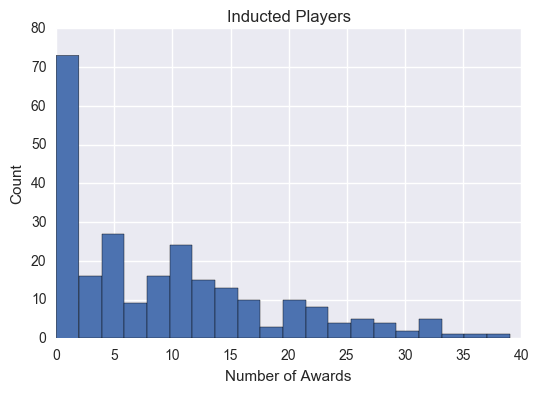

In [127]:
plot_awards(nominated_players[nominated_players.inducted == 'Y'], 'Inducted Players')

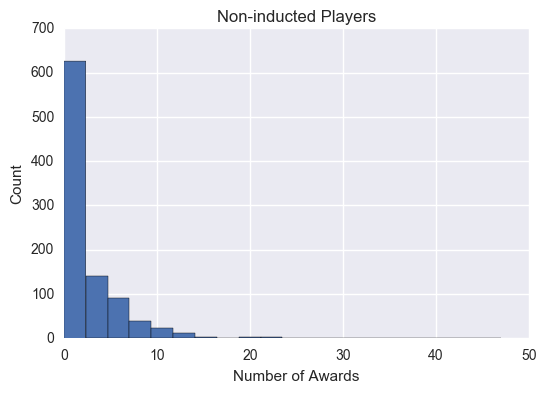

In [128]:
plot_awards(nominated_players[nominated_players.inducted == 'N'], 'Non-inducted Players')

To compare whether the means are actually different, we will use hypothesis testing. Since the distributions are non-normal, we will use the Mann-Whitney rank test.

The null hypothesis is that the mean number of awards is the same. The alternative hypothesis is that inducted players will have a higher average number of awards.

In [129]:
from scipy.stats import mannwhitneyu

mannwhitneyu(nominated_players[nominated_players.inducted == 'Y'].Awards,
            nominated_players[nominated_players.inducted == 'N'].Awards)

MannwhitneyuResult(statistic=63950.5, pvalue=1.0392213236359205e-29)

Since the p-value here is really small, we reject the null.

# Appearances
Number of games played could approximate longevity, which Hall voters could be rewarding.

In [130]:
def cumulative_stats(csv_path, display_head=True, agg_dict=None):
    """Computes aggregate stats from a CSV.
    
    Loads a CSV denoted by csv_path, groups by playerID. By default, numeric
    columns will be summed unless functions are specified in agg_dict.
    """
    df = pd.read_csv(csv_path)
    
    if display_head == True:
        display(df.head())
    
    df_total = None
    
    if agg_dict is None:
        df_total = df.groupby('playerID', as_index=False).sum()
        del df_total['yearID']
    else:
        df_total = df.groupby('playerID', as_index=False).agg(agg_dict)
    
    return df_total

# Merge with Appearances
appearances_total = cumulative_stats("baseballdatabank-master/core/Appearances.csv", display_head=False)
appearances_total.fillna(0, inplace=True)

appearances_total.head()

,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,aardsda01,331.0,0.0,139,331.0,331,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,aaronha01,3298.0,288.0,3298,3057.0,0,0,210,43,7,0,313,293,2184,2760,196.0,46.0,0.0
2,aaronto01,437.0,0.0,437,437.0,0,0,232,7,10,0,136,1,2,138,0.0,0.0,0.0
3,aasedo01,448.0,0.0,81,448.0,448,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,abadan01,15.0,4.0,15,9.0,0,0,8,0,0,0,0,0,1,1,0.0,7.0,1.0


## Positions
We also use the appearances data to determine the player's most played position. We will use this to compare traits amongst players later.

In [131]:
nominated_players = pd.merge(nominated_players, appearances_total, on='playerID')

# position_cols = ['G_p','G_c','G_1b','G_2b',
#                  'G_3b','G_ss','G_lf','G_cf',
#                  'G_rf','G_of','G_dh','G_ph','G_pr']

position_cols = ['G_p','G_c','G_1b','G_2b',
                 'G_3b','G_ss','G_of','G_dh','G_ph','G_pr']

def most_played_position(df):
    return df[position_cols].idxmax(axis=1).str.split('_').str[1].str.upper()

nominated_players.insert(3, 'Position', most_played_position(nominated_players))
display(nominated_players.head())

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,cobbty01,Ty,Cobb,OF,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0,3034.0,0.0,3034,3034.0,3,0,14,2,1,0,35,2194,706,2934,0.0,0.0,0.0
1,ruthba01,Babe,Ruth,OF,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,2503.0,0.0,2503,2503.0,163,0,32,0,0,0,1057,64,1131,2241,0.0,0.0,0.0
2,wagneho01,Honus,Wagner,SS,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2794.0,0.0,2794,2794.0,2,0,248,57,210,1887,35,67,272,373,0.0,0.0,0.0
3,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,647.0,0.0,647,647.0,636,0,3,0,0,0,1,0,3,4,0.0,0.0,0.0
4,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,934.0,0.0,934,934.0,802,0,0,0,0,0,2,7,4,13,0.0,0.0,0.0


Out of all the positions, we can see that pitchers are represented the most in our dataset:

In [132]:
nominated_players.Position.value_counts()

P     394
OF    297
C     101
1B    100
2B     88
3B     86
SS     84
DH      8
PH      4
Name: Position, dtype: int64

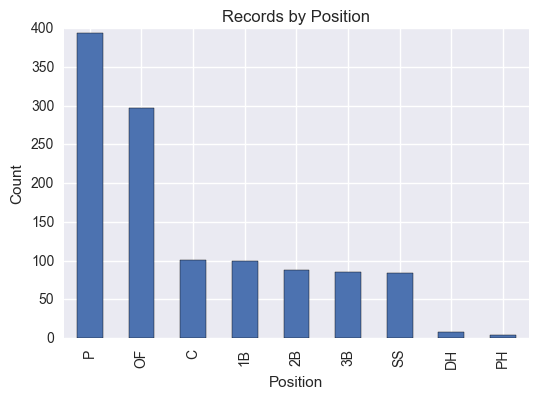

In [133]:
ax = nominated_players.Position.value_counts().plot.bar()
ax.set_title("Records by Position")
ax.set_ylabel("Count")
ax.set_xlabel("Position");

## Pitching

In [134]:
agg_dict = {'ERA': np.mean, 'W': np.sum, 'L': np.sum}
pitching_total = cumulative_stats("baseballdatabank-master/core/Pitching.csv", 
                                  display_head=False,
                                  agg_dict=agg_dict)

nominated_players = pd.merge(nominated_players, pitching_total, on='playerID', how='left')

## Batting
I merged in hitting statistics and computed the common sabermetric statistics of on-base percentage (OBP), slugging percentage (SLG), and on-base plus slugging (OPS).

In [135]:
def slugging_pct(df):
    return ((df['H'] - df['2B'] - df['3B'] - df['HR']) + 2*df['2B'] + 3*df['3B'] + 4*df['HR']) / df['AB']

def on_base_pct(df):
    return (df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['SF'] + df['HBP'])

def on_base_plus_slugging(df):
    return on_base_pct(df) + slugging_pct(df)

def add_hitting_stats(df):
    df['BA'] = df.H / df.AB
    df['SLG'] = slugging_pct(df)
    df['OBP'] = on_base_pct(df)
    df['OPS'] = on_base_plus_slugging(df)

In [136]:
batting_total = cumulative_stats("baseballdatabank-master/core/Batting.csv", 
                                  display_head=False)

nominated_players = pd.merge(nominated_players, batting_total, on='playerID', how='left')

nominated_players.fillna(0, inplace=True)

add_hitting_stats(nominated_players)

# Fielding

In [137]:
fielding_total = cumulative_stats("baseballdatabank-master/core/Fielding.csv", display_head=False)

fielding_total['E/G'] = fielding_total['E'] / fielding_total['G']
fielding_total['ZR/G'] = fielding_total['ZR'] / fielding_total['G']

fielding_total.rename(columns = {'CS': 'Opponent CS', 'SB': 'Opponent SB'}, inplace = True)

fielding_total.fillna(0, inplace=True)

nominated_players = pd.merge(nominated_players, fielding_total, on='playerID', how='left')

nominated_players.head()

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards,G_all,GS_x,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,ERA,W,L,stint_x,G_x,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,BA,SLG,OBP,OPS,stint_y,G_y,GS_y,InnOuts,PO,A,E,DP,PB,WP,Opponent SB,Opponent CS,ZR,E/G,ZR/G
0,cobbty01,Ty,Cobb,OF,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0,3034.0,0.0,3034,3034.0,3,0,14,2,1,0,35,2194,706,2934,0.0,0.0,0.0,2.250000,0.0,0.0,24,3035,11434.0,2246.0,4189.0,724.0,295.0,117.0,1937.0,892.0,178.0,1249.0,357.0,0.0,94.0,295.0,0.0,0.0,0.366363,0.511982,0.432965,0.944947,31,2954,0.0,0.0,6507.0,410.0,278.0,113.0,0.0,0.0,0.0,0.0,0.0,0.094110,0.0
1,ruthba01,Babe,Ruth,OF,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,2503.0,0.0,2503,2503.0,163,0,32,0,0,0,1057,64,1131,2241,0.0,0.0,0.0,3.680000,94.0,46.0,22,2503,8398.0,2174.0,2873.0,506.0,136.0,714.0,2217.0,123.0,117.0,2062.0,1330.0,0.0,43.0,113.0,0.0,2.0,0.342105,0.689807,0.473960,1.163767,38,2436,0.0,0.0,4787.0,569.0,179.0,86.0,0.0,0.0,0.0,0.0,0.0,0.073481,0.0
2,wagneho01,Honus,Wagner,SS,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2794.0,0.0,2794,2794.0,2,0,248,57,210,1887,35,67,272,373,0.0,0.0,0.0,0.000000,0.0,0.0,21,2792,10430.0,1736.0,3415.0,640.0,252.0,101.0,1732.0,722.0,15.0,963.0,327.0,0.0,125.0,221.0,0.0,0.0,0.327421,0.466155,0.390953,0.857109,61,2775,0.0,0.0,7930.0,6781.0,825.0,963.0,0.0,0.0,0.0,0.0,0.0,0.297297,0.0
3,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,647.0,0.0,647,647.0,636,0,3,0,0,0,1,0,3,4,0.0,0.0,0.0,2.648889,373.0,188.0,19,646,1684.0,151.0,362.0,50.0,12.0,7.0,165.0,20.0,1.0,116.0,74.0,0.0,17.0,69.0,0.0,0.0,0.214964,0.271378,0.272427,0.543805,21,642,0.0,0.0,313.0,1506.0,56.0,44.0,0.0,0.0,0.0,0.0,0.0,0.087227,0.0
4,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,934.0,0.0,934,934.0,802,0,0,0,0,0,2,7,4,13,0.0,0.0,0.0,2.348095,417.0,279.0,21,933,2324.0,241.0,547.0,94.0,41.0,24.0,255.0,13.0,4.0,110.0,251.0,0.0,13.0,70.0,0.0,0.0,0.235370,0.342083,0.273805,0.615887,26,815,0.0,0.0,292.0,1352.0,53.0,72.0,0.0,0.0,0.0,0.0,0.0,0.065031,0.0


# Analysis

In [138]:
# Convert inducted Y/N to numeric for corrplot
def convert_inducted_to_numeric(s):
    if s == 'Y':
        return 1
    else:
        return 0

nominated_players['inducted'] = nominated_players['inducted'].apply(convert_inducted_to_numeric)

In [139]:
def corr_plot(corr, annot=False):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 7))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                square=True, xticklabels=corr.columns.values, 
                yticklabels=corr.columns.values, annot=annot,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

    ax.set_title("Correlation plot");

# Pitchers

Let's start by looking at pitchers.

Below we first list each statistic and its correlation with induction into the Hall of Fame. We also visualize this with a correlation plot.

The display below whos that Wins is most strongly correlated with entry into the Hall of Fame, followed by Losses and Awards. Losses seems counter-intuitive because we would expect this to be a negative trait. However, the correlation plot below shows that Wins and Losses are highly correlated (around 0.8). In other words, a pitcher who has a lot of wins will have more losses as well. 

Inducted           1.000000
Wins               0.611305
Losses             0.472997
Awards             0.472801
Errors             0.411778
Cy Young Award     0.261780
Games Played       0.261107
Batting Average    0.130200
ERA               -0.316926
Name: inducted, dtype: float64

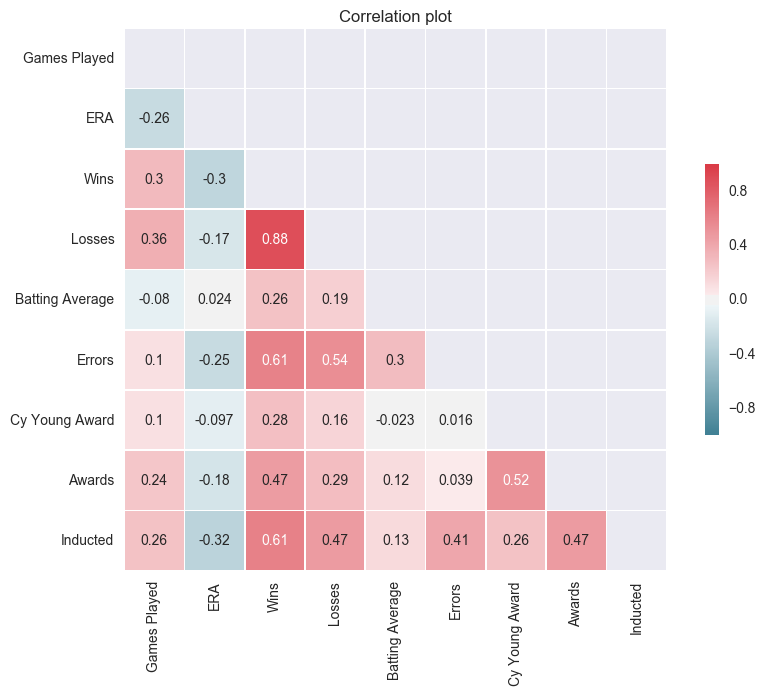

In [140]:
pitchers = nominated_players.loc[nominated_players.Position == 'P']

pitchers_corr = pitchers[['G_all', 'ERA', 'W', 'L', 'BA', 'E', 'Cy Young Award', 'Awards', 'inducted']].corr()
pitchers_corr.columns = ['Games Played', 'ERA', 'Wins', 'Losses', 'Batting Average', 'Errors', 'Cy Young Award', 'Awards', 'Inducted']

display(pitchers_corr.loc['inducted'].sort_values(ascending=False))
corr_plot(pitchers_corr, annot=True)

# Non-Pitchers

Next, we'll look at the set of non-pitchers. We'll do a similar analysis as we did for pitchers, but we'll include more hitting and fielding statistics.

In [141]:
# Merge with Batting
non_pitchers = nominated_players.loc[nominated_players.Position != 'P']

In [142]:
def create_corr_df(df):
    fielding_cols = ['A', 'E', 'DP', 'PB', 'WP', 'Opponent SB', 'Opponent CS', 'E/G']
    batting_cols = ['R', 'RBI', 'HR', 'H', 'SB', 'SO', 'BA', 'SLG', 'OBP', 'OPS']
    other_cols = ['G_all', 'Awards']
    
    # Human readable versions of statistics.
    fielding_human = ['Assists', 'Errors', 'Double Plays', 'Passed Balls', 
                      'Wild Pitch', 'Opp. Stolen Bases', 'Opp. Caught Stealing',
                     'Error / Game']
    batting_human = ['Runs', 'Runs Batted In', 'Home Runs', 
                        'Hits', 'Stolen Bases', 'Strike Outs', 'Batting Average', 
                        'On-base Percentage', 'Slugging Average', 'On-base Plus Slugging']
    other_human = ['Games', 'Awards']
    
    cols = other_cols + fielding_cols + batting_cols
    cols.append('inducted')
    
    corr = df[cols].corr()
    corr.columns = other_human + fielding_human + batting_human + ['Inducted']
    
    corr.index = list(corr.columns)
    
    return corr
    
def create_corr_plot(df, show_plot=True):
    corr = create_corr_df(df)
    
    display(corr.loc['Inducted'].sort_values(ascending=False))
    if show_plot == True:
        corr_plot(corr)
    
    return corr

As shown below, the offensive statistics as well as game played have higher correlation with induction than any of the fielding statistics listed below.

I adjusted a couple of the fielding statistics to be rate statistics (e.g. Errors per Game instead of Errors), but these new statistics were even less correlated with induction.

This suggests there may be a bias towards offensive statistics when voters are looking at non-pitchers.

Inducted                 1.000000
Runs                     0.545905
Awards                   0.535053
Hits                     0.523258
Runs Batted In           0.492232
Batting Average          0.448893
Games                    0.406961
Slugging Average         0.400916
On-base Plus Slugging    0.390291
On-base Percentage       0.338724
Errors                   0.284245
Stolen Bases             0.263113
Home Runs                0.238761
Assists                  0.168195
Double Plays             0.157303
Error / Game             0.068916
Strike Outs              0.036438
Passed Balls             0.021926
Opp. Stolen Bases       -0.017379
Opp. Caught Stealing    -0.027387
Wild Pitch              -0.038310
Name: Inducted, dtype: float64

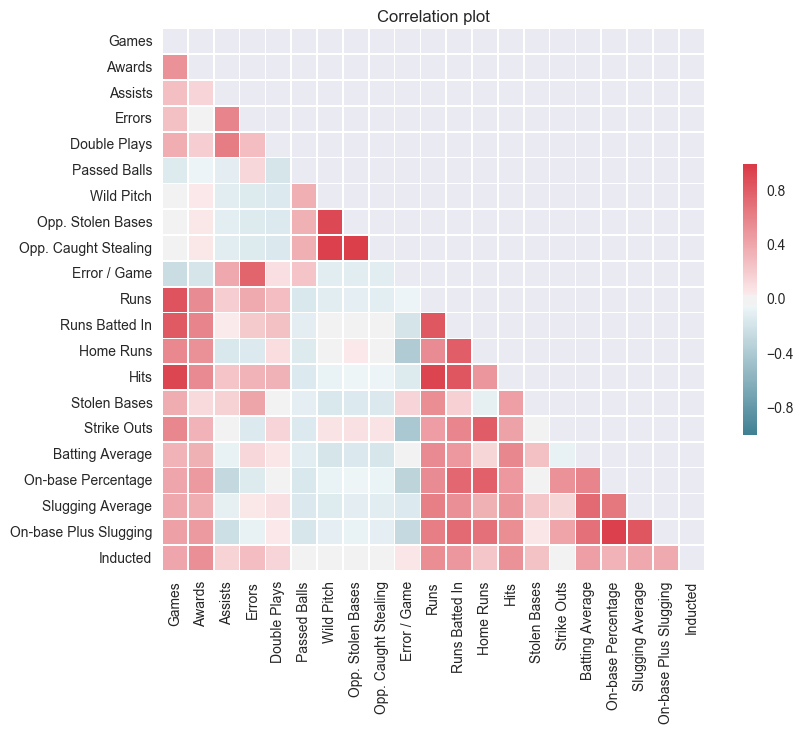

In [143]:
_ = create_corr_plot(non_pitchers)

### Correlations by Position
Let's break down non-pitchers by their position on the field and see if these correlations change at all. For brevity, we'll just use the display of the correlation statistics.

In [144]:
positions = ['OF', 'C', '1B', '2B', '3B', 'SS']

correlations = []

for pos in positions:
    correlations.append(create_corr_df(non_pitchers.loc[non_pitchers.Position == pos])['Inducted'])
    
position_corr = pd.concat(correlations, axis=1)
position_corr.columns = positions

cmap = sns.diverging_palette(220, 10, as_cmap=True)

position_corr.style.background_gradient(cmap=cmap)

Using the colors in the chart above, we can see that the correlations change by position:

* For outfielders, the top three most correlated stats are Runs, Hits, and Batting Average.
* For catchers, the top three are Awards, Runs Batted In, and Runs.
* For first basemen, it's Runs, Runs Batted In, and Batting Average.
* For second basemen, it's Awards, Assists, and Runs Batted In.
* For third basemen, it's Awards, Hits, and Batting Average.
* For shortstops, it's Runs Batted In, Awards, and Runs.

It's interesting to see that a fielding statistic like Assists seems to matter more for 2nd basemen than other positions. 

There are some missing values listed as 'nan' in the table. The cells that have 'nan' are for the catcher statistics of Passed Balls, Wild Pitch, and Opponent Caught Stealing. 

Let's look at shortstops who appeared as catchers:

In [107]:
non_pitchers.loc[(non_pitchers.Position == 'SS') & (non_pitchers.G_c > 0), ['playerID', 'nameFirst', 'nameLast', 'G_c', 'PB', 'WP', 'Opponent CS']]

,playerID,nameFirst,nameLast,G_c,PB,WP,Opponent CS
115,boudrlo01,Lou,Boudreau,3,0.0,0.0,0.0
344,campabe01,Bert,Campaneris,1,0.0,0.0,0.0
860,paganjo01,Jose,Pagan,1,0.0,0.0,0.0


We see that there are only three players who meet this criteria. We also see they played a combined total of five games and have no statistics for Passed Balls, Wild Pitch, or Caught Stealing.

### Hypothesis Testing
Let's test whether or not the number of runs scored for each position really varies by position.

In [149]:
non_pitchers.loc[non_pitchers.Position == 'OF', 'R'].mean()

970.50841750841755

In [160]:
mean_runs = [non_pitchers.loc[non_pitchers.Position == pos, 'R'].mean() for pos in positions]

std_runs = [non_pitchers.loc[non_pitchers.Position == pos, 'R'].std() for pos in positions]


position_stats = pd.DataFrame({'Runs': mean_runs, 'Std Dev': std_runs, 'Positions': positions})
position_stats

,Positions,Runs,Std Dev
0,OF,970.508418,428.409844
1,C,504.405941,278.858609
2,1B,968.080000,347.723903
3,2B,879.420455,379.892656
4,3B,836.081395,318.361955
5,SS,860.250000,361.524346


In [161]:
from scipy.stats import f_oneway

f_oneway(non_pitchers.loc[non_pitchers.Position == 'OF', 'R'],
         non_pitchers.loc[non_pitchers.Position == 'C', 'R'],
         non_pitchers.loc[non_pitchers.Position == '1B', 'R'],
         non_pitchers.loc[non_pitchers.Position == '2B', 'R'],
         non_pitchers.loc[non_pitchers.Position == '3B', 'R'],
         non_pitchers.loc[non_pitchers.Position == 'SS', 'R'])

F_onewayResult(statistic=24.850895932926008, pvalue=3.2567049301243443e-23)

## Steroids Era Analysis

Finally, I wanted to investigate how the steroids era might impact Hall of Fame voting. 

Per [ESPN](http://www.espn.com/mlb/topics/_/page/the-steroids-era), Major League Baseball experienced an increase in offensive output that resulted in unprecedented home run totals for power hitters. Just three players reached 50-home run mark in any season between 1961 and 1994, but many sluggers would start to surpass that number in the mid-90s.

Because the home run explosion occurred after 1994, I decided to use 1994 as the dividing line. I considered a player as belonging to the steroids era if their career had at least five seasons after 1994. I used the year of their final game to approximate this:

In [108]:
non_pitchers = pd.merge(non_pitchers, master_df[['playerID', 'finalGame']], on='playerID')
non_pitchers['Final Year'] = pd.DatetimeIndex(non_pitchers['finalGame']).year
sum((non_pitchers['Final Year'] - 1994) >= 5)

128

In [109]:
non_steroids_era = non_pitchers.loc[non_pitchers['Final Year'] - 1994 < 5]
steroids_era = non_pitchers.loc[non_pitchers['Final Year'] - 1994 >= 5]

In [110]:
steroids_corr = pd.concat({'Non-Steroids': create_corr_df(non_steroids_era)['Inducted'],
          'Steroids': create_corr_df(steroids_era)['Inducted']}, axis=1)
steroids_corr.style.background_gradient(cmap=cmap)

We can see that offensive statistics seem to matter less with the steroids era players, as correlations for Runs, RBI, Home Runs, and Hits all decrease when we look from non-steroid era players to steroid era players.

This suggests that Hall of Fame voters may be discounting offensive statistics for players from the steroids era.

# Conclusion
In this report, we found some statistics that correlate with entry into the Hall of Fame and investigated whether or not voters may or may not be discounting offensive stats from the steroids era.

With that said, these conclusions are tentative and correlation does not imply causation. 